<a href="https://colab.research.google.com/github/kwanative/CS633-Natural-Language-Processing/blob/main/CS633_NLP_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 1: Exploring Word Vectors**

(https://web.stanford.edu/class/cs224n/assignments/a1_preview/exploring_word_vectors.html)

**รายชื่อสมาชิกกลุ่ม**

6409035323 นายพงศธร อุ่นตาล - มอส </br>
6409035620 น.ส.ลลิดา  ศรีเมือง - แต้ว </br>
6409035687 น.ส.ขนิษฐา วนะเจริญ - ขวัญ

In [2]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from platform import python_version
assert int(python_version().split(".")[1]) >= 5, "Please upgrade your Python version following the instructions in \
    the README.txt file found in the same directory as this notebook. Your Python version is " + python_version()

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters') #to specify download location, optionally add the argument: download_dir='/specify/desired/path/'
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...


In [3]:
def read_corpus(category="grain"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]

In [4]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'china', 'daily', 'says', 'vermin', 'eat', '7', '-', '12', 'pct', 'grain', 'stocks',
  'a', 'survey', 'of', '19', 'provinces', 'and', 'seven', 'cities', 'showed', 'vermin', 'consume',
  'between', 'seven', 'and', '12', 'pct', 'of', 'china', "'", 's', 'grain', 'stocks', ',', 'the',
  'china', 'daily', 'said', '.', 'it', 'also', 'said', 'that', 'each', 'year', '1', '.', '575',
  'mln', 'tonnes', ',', 'or', '25', 'pct', ',', 'of', 'china', "'", 's', 'fruit', 'output', 'are',
  'left', 'to', 'rot', ',', 'and', '2', '.', '1', 'mln', 'tonnes', ',', 'or', 'up', 'to', '30',
  'pct', ',', 'of', 'its', 'vegetables', '.', 'the', 'paper', 'blamed', 'the', 'waste', 'on',
  'inadequate', 'storage', 'and', 'bad', 'preservation', 'methods', '.', 'it', 'said', 'the',
  'government', 'had', 'launched', 'a', 'national', 'programme', 'to', 'reduce', 'waste', ',',
  'calling', 'for', 'improved', 'technology', 'in', 'storage', 'and', 'preservation', ',', 'and',
  'greater', 'production', 'of', 

# **1.1 Implement distinct_words**

In [30]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            n_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    n_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    #
    corpus_words = sorted(list(set([word for words_list in corpus for word in words_list])))
    n_corpus_words = len(corpus_words)
    #
    # ------------------

    return corpus_words, n_corpus_words

In [31]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# **1.2: Implement compute_co_occurrence_matrix**

In [55]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, n_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    #
    M = np.zeros((n_words, n_words))
    word2ind = dict(zip(words, range(n_words)))
    
    for doc in corpus:
        current_idx = 0
        doc_len = len(doc)
        while current_idx < doc_len:
            print ("doc:", current_idx, doc[current_idx])
            left_boudary = max(current_idx-window_size, 0)
            right_boundary = min(current_idx+window_size+1, doc_len)
            outside_words = doc[left_boudary:current_idx] + doc[current_idx+1:right_boundary]
            center_word = doc[current_idx]
            center_idx = word2ind[center_word]
            
            for outside_word in outside_words:
                outside_idx = word2ind[outside_word]
                M[outside_idx, center_idx] += 1
            
            current_idx += 1
    #
    # ------------------

    return M, word2ind

In [57]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

doc: 0 <START>
doc: 1 All
doc: 2 that
doc: 3 glitters
doc: 4 isn't
doc: 5 gold
doc: 6 <END>
doc: 0 <START>
doc: 1 All's
doc: 2 well
doc: 3 that
doc: 4 ends
doc: 5 well
doc: 6 <END>
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


In [58]:
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

doc: 0 <START>
doc: 1 All
doc: 2 that
doc: 3 glitters
doc: 4 isn't
doc: 5 gold
doc: 6 <END>
doc: 0 <START>
doc: 1 All's
doc: 2 well
doc: 3 that
doc: 4 ends
doc: 5 well
doc: 6 <END>


In [59]:
distinct_words(test_corpus)

(['<END>',
  '<START>',
  'All',
  "All's",
  'ends',
  'glitters',
  'gold',
  "isn't",
  'that',
  'well'],
 10)

In [23]:
test_corpus

[['<START>', 'All', 'that', 'glitters', "isn't", 'gold', '<END>'],
 ['<START>', "All's", 'well', 'that', 'ends', 'well', '<END>']]

In [24]:
word2ind_test

{'<END>': 0,
 '<START>': 1,
 'All': 2,
 "All's": 3,
 'ends': 4,
 'glitters': 5,
 'gold': 6,
 "isn't": 7,
 'that': 8,
 'well': 9}

In [25]:
word2ind_ans

{'<END>': 0,
 '<START>': 1,
 'All': 2,
 "All's": 3,
 'ends': 4,
 'glitters': 5,
 'gold': 6,
 "isn't": 7,
 'that': 8,
 'well': 9}

# **1.3: Implement reduce_to_k_dim**

In [26]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
    # ------------------
    # Write your implementation here.
    #
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)
    #
    # ------------------

    print("Done.")
    return M_reduced

In [27]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


# **1.4: Implement plot_embeddings**

In [28]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    #
    x_coords = M_reduced[:, 0]
    y_coords = M_reduced[:, 1]
    
    for word in words:
        idx = word2ind[word]
        embedding = M_reduced[idx]
        x = embedding[0]
        y = embedding[1]
        
        plt.scatter(x, y, marker='x', color='red')
        plt.text(x, y, word, fontsize=9)
    #
    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


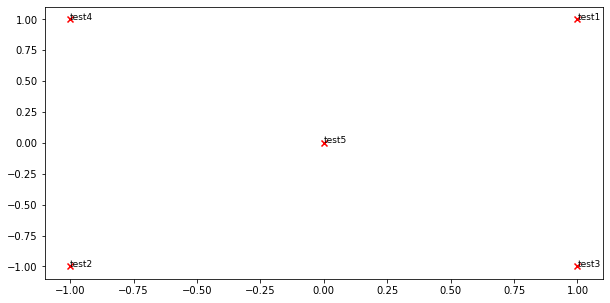

In [ ]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

# **1.5: Co-Occurrence Plot Analysis**

Running Truncated SVD over 7146 words...
Done.


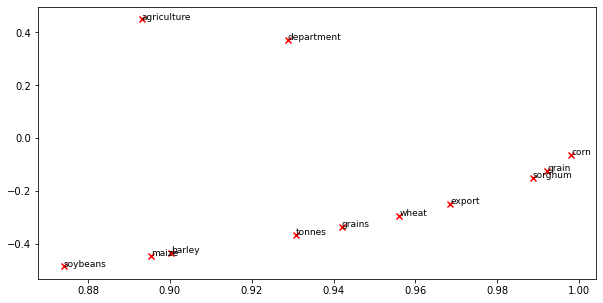

In [29]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['tonnes', 'grain', 'wheat',  'agriculture', 'corn', 'maize', 'export', 'department', 'barley', 'grains', 'soybeans', 'sorghum']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

Ans:

จากกราฟจะเห็นว่ากลุ่มคำที่มีความใกล้เคียงกันจัดได้เป็น 4 กลุ่ม ดังนี้
- agriculture, department
- soybeans, maiz, barley
- tonnes, grains, wheat, export
- sorgnum, grain, corn

</br>
สิ่งที่น่าสังเกตคือ maiz กับ corn, grain กับ grains มีความหมายเหมือนกัน แต่ทำไมมีความสัมพันธ์ไกลกัน